# Comparing CVaR vs Pure MAB Strategies

In [1]:
# pip install ECOS

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from numpy.random import rand, seed
import cvxpy as cp
from matplotlib.colors import to_rgba
from scipy.stats import mode
import yfinance as yf
import time

The stocks in our basket.

In [3]:
# # Sorted tickers
tickers = sorted(['PFE', 'WMT', 'KR', 'NFLX', 'AAPL', 'TSLA', 'AMZN', 'GOOG', 'META'])

We will use the data from January 2023 through December 2024 for training, and then use the result of the training for a *warm start* for the testing phase, January 2025 through May 16, 2025.

- The first trading day of 2023 is January 3 and the final trading day of 2024 is December 31.
- The first trading day of 2025 is January 2, 2025.

In [4]:
YData = pd.read_csv("adj_close_2023_2025.csv")

In [5]:
YData

,Date,AAPL,AMZN,GOOG,KR,META,NFLX,PFE,TSLA,WMT
0,2023-01-03,123.470612,85.820000,89.277138,42.025764,124.154854,294.950012,44.607903,108.099998,46.349461
1,2023-01-04,124.744118,85.139999,88.291809,42.498276,126.772530,309.410004,43.624554,113.639999,46.401100
2,2023-01-05,123.421249,83.120003,86.360947,42.677834,126.344543,309.700012,43.215542,110.339996,46.242939
3,2023-01-06,127.962440,86.080002,87.744400,43.225960,129.410095,315.549988,44.312023,113.059998,47.375858
4,2023-01-09,128.485657,87.360001,88.381386,43.651215,128.862671,315.170013,42.110355,119.769997,46.785191
...,...,...,...,...,...,...,...,...,...,...
590,2025-05-12,210.789993,208.639999,159.580002,68.706978,639.429993,1110.000000,23.090000,318.380005,96.750000
591,2025-05-13,212.929993,211.369995,160.889999,67.164452,656.030029,1138.439941,22.870001,334.070007,95.879997
592,2025-05-14,212.330002,210.250000,166.809998,66.019997,659.359985,1150.989990,22.020000,347.679993,96.830002
593,2025-05-15,211.449997,205.169998,165.399994,67.599998,643.880005,1177.979980,22.600000,342.820007,96.349998


In [6]:
# Convert 'Date' column to datetime
YData["Date"] = pd.to_datetime(YData["Date"])

# Sort just in case (optional but safe)
YData = YData.sort_values("Date").reset_index(drop=True)

In [7]:
# Split dates
cutoff_2024 = pd.to_datetime("2024-12-31")

# Get index of the last row of 2024
last_2024_idx = YData[YData["Date"] <= cutoff_2024].index.max()

# Create the two new dataframes
YData2025 = YData.iloc[last_2024_idx:].reset_index(drop=True)
YData = YData[YData["Date"] <= cutoff_2024].reset_index(drop=True)

In [8]:
YData2025.head(3)

,Date,AAPL,AMZN,GOOG,KR,META,NFLX,PFE,TSLA,WMT
0,2024-12-31,249.817383,219.389999,190.223282,60.558319,584.989563,891.320007,25.609970,403.839996,89.885246
1,2025-01-02,243.263199,220.220001,190.413071,61.340672,598.707336,886.729980,25.687197,379.279999,89.537041
2,2025-01-03,242.774368,224.190002,192.910233,60.865318,604.092529,881.049988,25.667889,410.440002,90.313026


In [9]:
YData2025.tail(3)

,Date,AAPL,AMZN,GOOG,KR,META,NFLX,PFE,TSLA,WMT
91,2025-05-14,212.330002,210.250000,166.809998,66.019997,659.359985,1150.989990,22.02,347.679993,96.830002
92,2025-05-15,211.449997,205.169998,165.399994,67.599998,643.880005,1177.979980,22.60,342.820007,96.349998
93,2025-05-16,211.259995,205.589996,167.429993,68.849998,640.340027,1191.530029,22.83,349.980011,98.239998


In [10]:
# Compute daily simple returns
returns = YData[tickers].pct_change().dropna()
returns["Date"] = YData["Date"].iloc[1:].values
returns = returns[["Date"] + tickers]
# Compute correlation matrix on returns
corr_matrix = returns[tickers].corr()

In [11]:
returns.head(3)

,Date,AAPL,AMZN,GOOG,KR,META,NFLX,PFE,TSLA,WMT
1,2023-01-04,0.010314,-0.007924,-0.011037,0.011243,0.021084,0.049025,-0.022044,0.051249,0.001114
2,2023-01-05,-0.010605,-0.023726,-0.021869,0.004225,-0.003376,0.000937,-0.009376,-0.029039,-0.003409
3,2023-01-06,0.036794,0.035611,0.016019,0.012843,0.024263,0.018889,0.025372,0.024651,0.024499


In [12]:
returns2025 = YData2025[tickers].pct_change().dropna()
returns2025["Date"] = YData2025["Date"].iloc[1:].values  # skip the first row
returns2025 = returns2025[["Date"] + tickers]            # reorder columns
returns2025 = returns2025[1:]
# returns2025 = returns2025.reset_index(drop=True)         # reset index cleanly

In [13]:
returns2025.head(3)

,Date,AAPL,AMZN,GOOG,KR,META,NFLX,PFE,TSLA,WMT
2,2025-01-03,-0.002009,0.018027,0.013114,-0.007749,0.008995,-0.006406,-0.000752,0.082156,0.008667
3,2025-01-06,0.006739,0.015255,0.025009,-0.013667,0.042290,0.000840,0.011282,0.001486,0.007160
4,2025-01-07,-0.011388,-0.024164,-0.006314,-0.024414,-0.019534,-0.002949,0.008925,-0.040603,-0.006781


Let's get an idea of the correlation between returns data. We split the analysis into the training and testing sets.

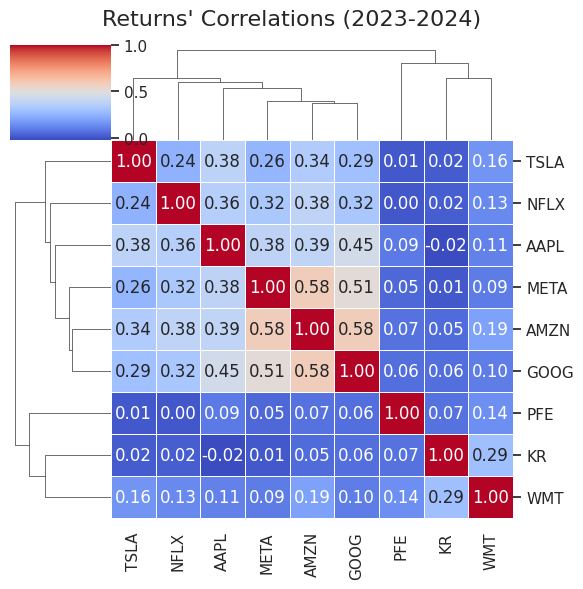

In [14]:
sns.set(style="white")
cluster = sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    figsize=(6, 6),
    row_cluster=True,
    col_cluster=True
)

cluster.fig.subplots_adjust(top=0.92)
cluster.fig.suptitle("Returns' Correlations (2023-2024)", fontsize=16)
cluster.savefig("heatmap.png", dpi=300)
plt.show()

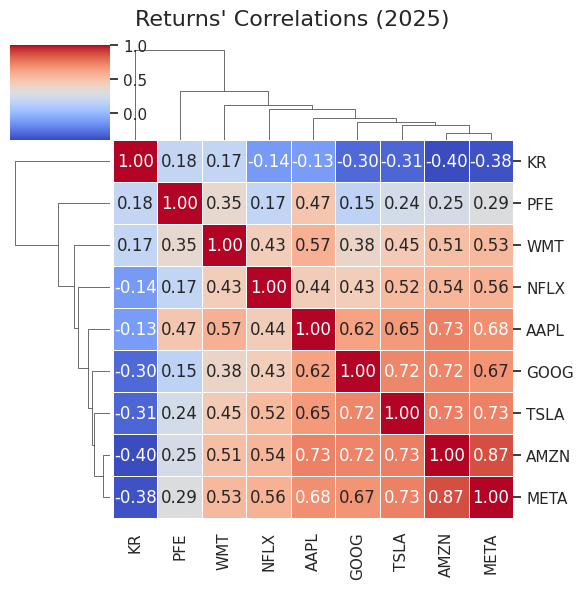

In [15]:
# Compute correlation matrix on returns
corr_matrix2025 = returns2025[tickers].corr()
sns.set(style="white")
cluster2025 = sns.clustermap(
    corr_matrix2025,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    figsize=(6, 6),
    row_cluster=True,
    col_cluster=True
)

cluster2025.fig.subplots_adjust(top=0.92)
cluster2025.fig.suptitle("Returns' Correlations (2025)", fontsize=16)
cluster2025.savefig("heatmap2025.png", dpi=300)
plt.show()

In [16]:
# Set 'Date' as index temporarily for plotting
YData_plot = YData.set_index("Date")
YData2025_plot = YData2025.set_index("Date")

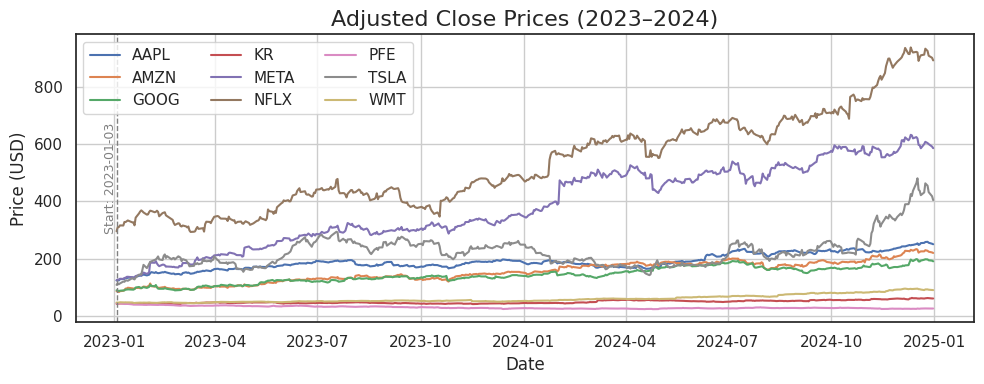

In [17]:
plt.figure(figsize=(10, 4))

# Plot all tickers
for ticker in tickers:
    plt.plot(YData_plot.index, YData_plot[ticker], label=ticker)

# Plot aesthetics
plt.title("Adjusted Close Prices (2023–2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(loc="upper left", ncol=3)
plt.grid(True)
plt.tight_layout()

# --- Add vertical line and annotation for start ---
start_date = YData_plot.index[0]
plt.axvline(start_date, color='gray', linestyle='--', linewidth=1)

# Center the annotation vertically
ymin, ymax = plt.ylim()
ycenter = (ymin + ymax) / 2

plt.text(
    start_date, ycenter,
    f"Start: {start_date.strftime('%Y-%m-%d')}",
    rotation=90,
    verticalalignment='center',
    horizontalalignment='right',
    fontsize=9,
    color='gray'
)

# Save and show
plt.savefig("price.png", dpi=300)
plt.show()

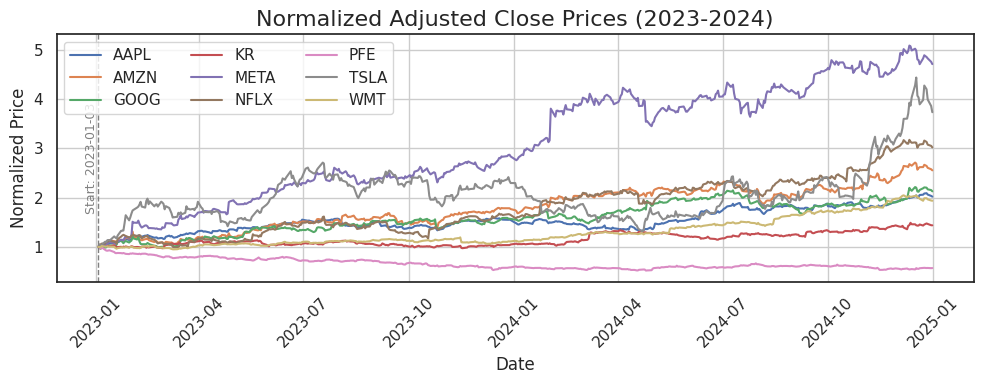

In [18]:
normalized = YData_plot[tickers] / YData_plot[tickers].iloc[0]

plt.figure(figsize=(10, 4))
for ticker in tickers:
    plt.plot(normalized[ticker], label=ticker)

plt.title("Normalized Adjusted Close Prices (2023-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Normalized Price", fontsize=12)
plt.legend(loc="upper left", ncol=3)
plt.grid(True)
plt.tight_layout()
# --- Add vertical line and annotation for start ---
start_date = YData_plot.index[0]
plt.axvline(start_date, color='gray', linestyle='--', linewidth=1)

# Center the annotation vertically
ymin, ymax = plt.ylim()
ycenter = (ymin + ymax) / 2

plt.text(
    start_date, ycenter,
    f"Start: {start_date.strftime('%Y-%m-%d')}",
    rotation=90,
    verticalalignment='center',
    horizontalalignment='right',
    fontsize=9,
    color='gray'
)
plt.savefig("norm_price.png", dpi=300)
plt.show()

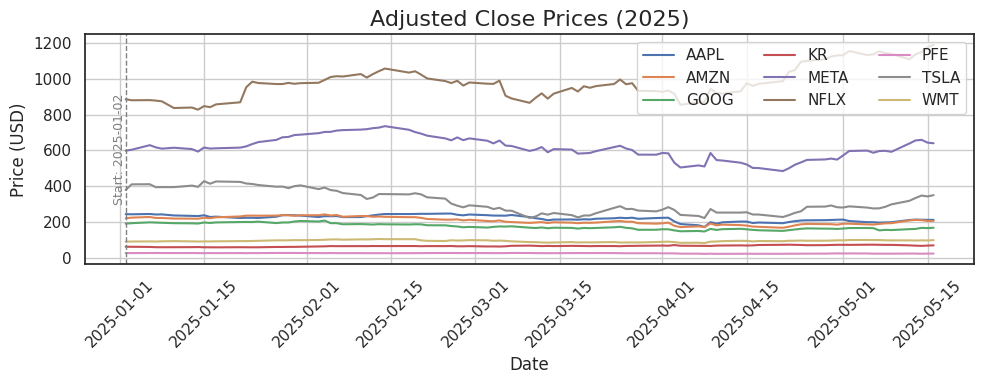

In [19]:
plt.figure(figsize=(10, 4))
for ticker in tickers:
    plt.plot(YData2025_plot[ticker][1:], label=ticker)

plt.title("Adjusted Close Prices (2025)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(loc="upper right", ncol=3)
plt.grid(True)
plt.tight_layout()
# --- Add vertical line and annotation for start ---
start_date = YData2025_plot.index[1]
plt.axvline(start_date, color='gray', linestyle='--', linewidth=1)

# Center the annotation vertically
ymin, ymax = plt.ylim()
ycenter = (ymin + ymax) / 2

plt.text(
    start_date, ycenter,
    f"Start: {start_date.strftime('%Y-%m-%d')}",
    rotation=90,
    verticalalignment='center',
    horizontalalignment='right',
    fontsize=9,
    color='gray'
)
plt.savefig("price2025.png", dpi=300)
plt.show()

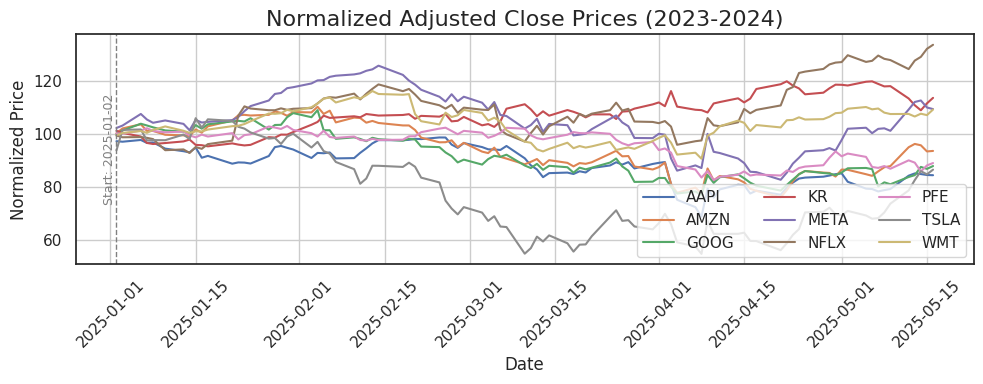

In [20]:
normalized2025 = YData2025_plot[tickers] / YData2025_plot[tickers].iloc[0] * 100

plt.figure(figsize=(10, 4))
for ticker in tickers:
    plt.plot(normalized2025[ticker][1:], label=ticker)

plt.title("Normalized Adjusted Close Prices (2023-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Normalized Price", fontsize=12)
plt.legend(loc="lower right", ncol=3)
plt.grid(True)
plt.tight_layout()
# --- Add vertical line and annotation for start ---
start_date = YData2025_plot.index[1]
plt.axvline(start_date, color='gray', linestyle='--', linewidth=1)

# Center the annotation vertically
ymin, ymax = plt.ylim()
ycenter = (ymin + ymax) / 2

plt.text(
    start_date, ycenter,
    f"Start: {start_date.strftime('%Y-%m-%d')}",
    rotation=90,
    verticalalignment='center',
    horizontalalignment='right',
    fontsize=9,
    color='gray'
)
plt.savefig("norm_price2025.png", dpi=300)
plt.show()

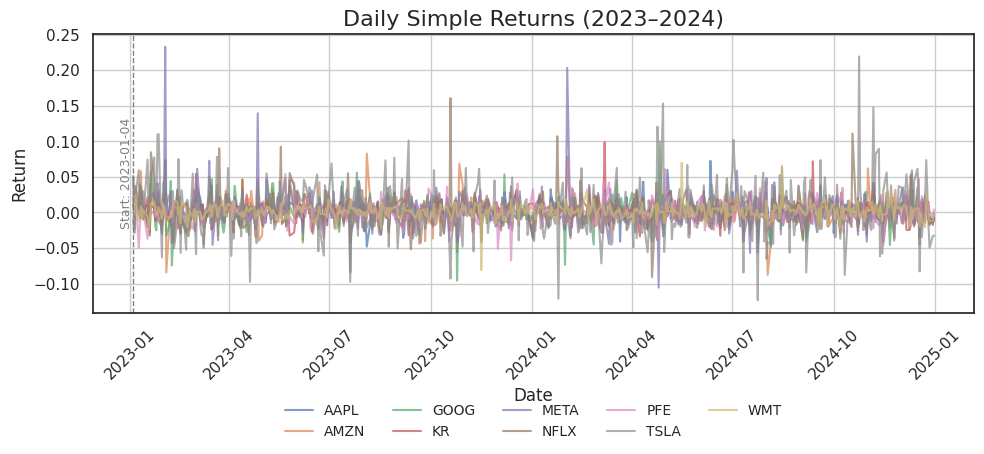

In [21]:
plt.figure(figsize=(10, 5))
for ticker in tickers:
    plt.plot(returns["Date"], returns[ticker], label=ticker, alpha=0.7)

plt.title("Daily Simple Returns (2023–2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Return", fontsize=12)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.28),
    ncol=5,
    fontsize=10,
    frameon=False
)
plt.grid(True)
plt.tight_layout()
# --- Add vertical line and annotation for start ---
start_date = returns["Date"].iloc[0]
plt.axvline(start_date, color='gray', linestyle='--', linewidth=1)

# Center the annotation vertically
ymin, ymax = plt.ylim()
ycenter = (ymin + ymax) / 2

plt.text(
    start_date, ycenter,
    f"Start: {start_date.strftime('%Y-%m-%d')}",
    rotation=90,
    verticalalignment='center',
    horizontalalignment='right',
    fontsize=9,
    color='gray'
)
plt.savefig("returns.png", dpi=300, bbox_inches="tight")
plt.show()

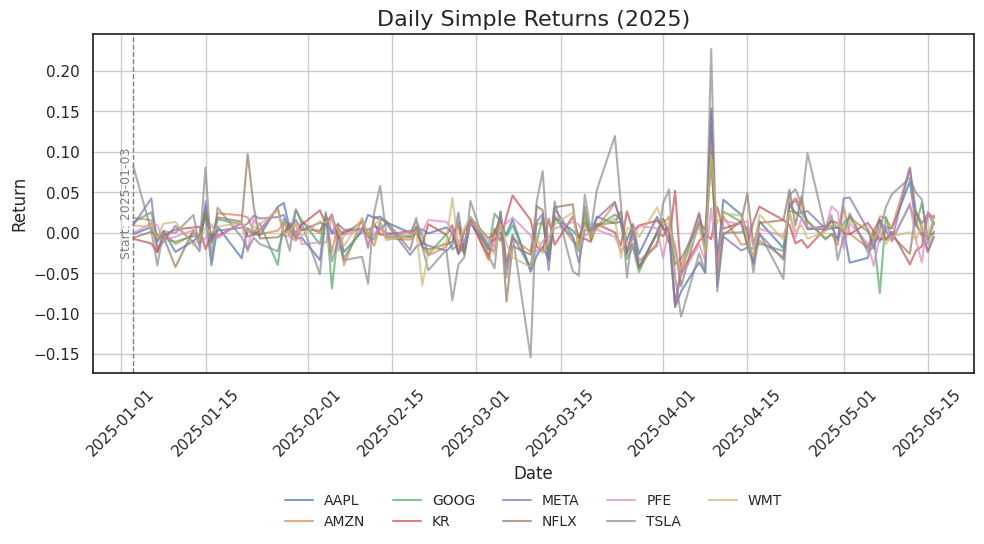

In [22]:
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(returns2025["Date"], returns2025[ticker], label=ticker, alpha=0.7)

plt.title("Daily Simple Returns (2025)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Return", fontsize=12)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.32),
    ncol=5,
    fontsize=10,
    frameon=False
)
plt.grid(True)
plt.tight_layout()
# --- Add vertical line and annotation for start ---
start_date = returns2025["Date"].iloc[0]
plt.axvline(start_date, color='gray', linestyle='--', linewidth=1)

# Center the annotation vertically
ymin, ymax = plt.ylim()
ycenter = (ymin + ymax) / 2

plt.text(
    start_date, ycenter,
    f"Start: {start_date.strftime('%Y-%m-%d')}",
    rotation=90,
    verticalalignment='center',
    horizontalalignment='right',
    fontsize=9,
    color='gray'
)
plt.savefig("returns2025.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
# Compute the best performing stock and return value each day
best_ticker = returns[tickers].idxmax(axis=1)
best_return = returns[tickers].max(axis=1)

oracle = pd.DataFrame({
    'Date': returns['Date'],
    'BestStock': best_ticker,
    'BestReturn': best_return
})

oracle.head()

,Date,BestStock,BestReturn
1,2023-01-04,TSLA,0.051249
2,2023-01-05,KR,0.004225
3,2023-01-06,AAPL,0.036794
4,2023-01-09,TSLA,0.059349
5,2023-01-10,NFLX,0.039249


In [24]:
# Compute the best performing stock and return value each day
best_ticker2025 = returns2025[tickers].idxmax(axis=1)
best_return2025 = returns2025[tickers].max(axis=1)

oracle2025 = pd.DataFrame({
    'Date': returns2025['Date'],
    'BestStock': best_ticker2025,
    'BestReturn': best_return2025
})

oracle2025.head()

,Date,BestStock,BestReturn
2,2025-01-03,TSLA,0.082156
3,2025-01-06,META,0.042290
4,2025-01-07,PFE,0.008925
5,2025-01-08,WMT,0.010902
6,2025-01-10,WMT,0.013072


## Blended Strategy: CVaR + UCB + $\varepsilon$-Greedy

In [25]:
def compute_combined_portfolios(
    data,
    NEPISODES,
    lambda_,
    EPSILON,
    HOLD=1,
    ALPHA=0.8,
    SEED_VALUE=1234,
    data_old=None,
    ini_weight=None,
    init_qvalues=None,
    init_nactions=None
):
    import numpy as np
    import cvxpy as cp
    import pandas as pd
    from numpy.random import seed, rand, randint

    min_history = 30
    returns = data.pct_change().dropna().reset_index(drop=True)
    NK = data.shape[1]
    TMAX = data.shape[0] - HOLD - 1
    date_index = data.index[HOLD:]

    reward_blended_all = np.zeros((NEPISODES, TMAX + 1))
    regret_blended_all = np.zeros((NEPISODES, TMAX + 1))
    picked_stock_blended_all = np.zeros((NEPISODES, TMAX + 1), dtype=int)
    optimal_stock_all = np.zeros((NEPISODES, TMAX + 1), dtype=int)

    final_qvalues_all = np.zeros((NEPISODES, NK))
    final_nactions_all = np.zeros((NEPISODES, NK))
    weight_record = np.zeros((NEPISODES, TMAX + 1, NK))

    for episode in range(NEPISODES):
        seed(SEED_VALUE + episode)

        qvalues = np.zeros(NK) if init_qvalues is None else init_qvalues.copy()
        nactions = np.zeros(NK) if init_nactions is None else init_nactions.copy()
        qvalues_up = np.zeros(NK)
        reward_queue = np.zeros((HOLD, 2))

        last_valid_cvar = np.ones(NK) / NK
        beta = 0.95
        arm_order = np.random.permutation(NK)

        for tt in range(0, TMAX + 1):
            untouched = np.where(nactions == 0)[0]

            # === Selection logic ===
            if data_old is None and len(untouched) > 0:
                for arm in arm_order:
                    if arm in untouched:
                        action = arm
                        break
            else:
                if EPSILON > 0 and rand() < EPSILON:
                    action = randint(NK)
                else:
                    action = np.argmax(qvalues_up)

            nactions[action] += 1

            # Compute reward
            ret = (data.iloc[tt + HOLD] - data.iloc[tt]) / data.iloc[tt]
            reward = ret.iloc[action]
            reward_queue[HOLD - 1, 0] = reward
            reward_queue[HOLD - 1, 1] = action

            # Q-value update (alpha-learning)
            alpha = ALPHA
            qvalues[int(reward_queue[0, 1])] += alpha * (reward_queue[0, 0] - qvalues[int(reward_queue[0, 1])])

            # UCB1 update
            for a in range(NK):
                if nactions[a] == 0:
                    qvalues_up[a] = np.max(qvalues) + 1.0
                else:
                    qvalues_up[a] = qvalues[a] + np.sqrt(np.log(tt + 1) / nactions[a])

            reward_queue[0:HOLD - 1, :] = reward_queue[1:HOLD, :]

            # --- CVaR Optimization ---
            if data_old is not None:
                data_old_ret = data_old.pct_change().dropna().reset_index(drop=True)
                if tt < min_history:
                    num_needed_from_train = min_history - tt
                    recent_train_returns = data_old_ret.iloc[-num_needed_from_train:]
                    recent_test_returns = returns.iloc[:tt]
                    history = pd.concat([recent_train_returns, recent_test_returns], axis=0).values
                else:
                    history = returns.iloc[tt - min_history:tt].values
            else:
                history = returns.iloc[max(0, tt - min_history):tt].values

            if history.shape[0] < min_history:
                w_cvar = last_valid_cvar
            else:
                m = history.shape[0]
                w = cp.Variable(NK)
                a = cp.Variable()
                z = cp.Variable(m)
                constraints = [w >= 0, cp.sum(w) == 1, z >= -history @ w - a, z >= 0]
                objective = cp.Minimize(a + (1 / ((1 - beta) * m)) * cp.sum(z))
                prob = cp.Problem(objective, constraints)
                result = prob.solve(solver='ECOS', verbose=False)

                if w.value is not None:
                    w_cvar = np.array(w.value).flatten()
                    last_valid_cvar = w_cvar.copy()
                else:
                    w_cvar = last_valid_cvar

            if episode == 0 and tt == 0:
                print("==== CVaR Initialization Debug ====")
                print("Testing mode:" if data_old is not None else "Training mode:")
                print("Shape of CVaR history matrix:", history.shape)
                print("First 3 returns:\n", history[:3])
                print("Last 3 returns:\n", history[-3:])
                print("Computed w_cvar (rounded):", np.round(w_cvar, 4))
                print("===================================")

            e_at = np.zeros(NK)
            e_at[action] = 1.0

            if tt == 0 and ini_weight is not None and data_old is None:
                w_combined = ini_weight
            else:
                if lambda_ == 0:
                    w_combined = w_cvar
                elif lambda_ == 1:
                    w_combined = e_at
                else:
                    w_combined = lambda_ * e_at + (1 - lambda_) * w_cvar

            if episode == 0 and tt == 0:
                print("Stored weight_combined on Day 0:", w_combined.round(4))

            weight_record[episode, tt, :] = w_combined

            blended_return = np.dot(w_combined, ret.values)
            best_return = ret.max()
            best_stock = ret.values.argmax()
            regret = best_return - blended_return

            reward_blended_all[episode, tt] = blended_return
            regret_blended_all[episode, tt] = regret
            picked_stock_blended_all[episode, tt] = action
            optimal_stock_all[episode, tt] = best_stock

        final_qvalues_all[episode] = qvalues
        final_nactions_all[episode] = nactions

    return {
        "dates": date_index,
        "reward_blended_all": reward_blended_all,
        "regret_blended_all": regret_blended_all,
        "picked_stock_blended_all": picked_stock_blended_all,
        "optimal_stock_all": optimal_stock_all,
        "final_qvalues_all": final_qvalues_all,
        "final_nactions_all": final_nactions_all,
        "weights_all": weight_record
    }

In [26]:
def plot_blended_vs_oracles(
    dates,
    reward_blended,
    data,
    picked_stock_blended_all,
    optimal_stock_all,
    save_image,
    model,
    asset_names=None,
    HOLD=1
):
    T = len(reward_blended)
    assert len(dates) >= T, "Mismatch between dates and reward length"
    plot_dates = dates[:T]  # length = len(reward)

    best_returns = np.zeros(T)
    best_overall_stock_returns = np.zeros(T)
    best_assets = np.zeros(T, dtype=int)

    # Identify best overall stock over entire period
    overall_return = (data.iloc[-1] - data.iloc[0]) / data.iloc[0]
    best_stock_index = overall_return.values.argmax()

    for t in range(T):
        ret_t = (data.iloc[t + HOLD] - data.iloc[t]) / data.iloc[t]
        best_returns[t] = ret_t.max()
        best_assets[t] = ret_t.values.argmax()
        best_overall_stock_returns[t] = ret_t.iloc[best_stock_index]

    # Compute proportion of optimal selections (across episodes)
    picked_correctly = picked_stock_blended_all == optimal_stock_all
    avg_optimal_blended = picked_correctly.mean(axis=0)

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(10, 4))

    line1 = ax1.plot(plot_dates, reward_blended, label=f"{model} Strategy Return", color="blue")
    line2 = ax1.plot(plot_dates, best_returns, label="Best Daily Return (Oracle)", color="orange", alpha=0.3)
    line3 = ax1.plot(plot_dates, best_overall_stock_returns, label="Best Overall Stock", color="green", alpha=0.3)

    # Mark and annotate the start of the plot
    start_date = plot_dates.iloc[0]
    ax1.axvline(start_date, color='gray', linestyle='--', linewidth=1)

    # Compute vertical center of y-axis
    ymin, ymax = ax1.get_ylim()
    ycenter = (ymin + ymax) / 2

    # Rotated, centered, left-of-line annotation
    ax1.text(
        start_date, ycenter,
        f"Start: {start_date.strftime('%Y-%m-%d')}",
        rotation=90,
        verticalalignment='center',
        horizontalalignment='right',  # ← to place it left of the line
        fontsize=8,
        color='gray'
    )

    ax1.set_xlabel("Date", fontsize=9)
    ax1.set_ylabel("Return", fontsize=9)
    ax1.set_title(f"{model} Strategy vs. Oracle and Best Stock Returns", fontsize=11)
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # Right y-axis: Proportion of Optimal Selections
    ax2 = ax1.twinx()
    bar4 = ax2.bar(
        plot_dates,
        avg_optimal_blended,
        width=1.0,
        alpha=0.25,
        color='brown',
        label="Proportion of Optimal Selections"
    )
    ax2.set_ylabel("Proportion of Optimal Selections", fontsize=9)

    # Annotate asset names
    if asset_names is not None:
        for i in range(0, T, max(1, T // 20)):
            ax1.annotate(
                asset_names[best_assets[i]],
                (plot_dates[i], ax1.get_ylim()[0]),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center',
                fontsize=8,
                color='black',
                rotation=45
            )

    # Combine legends
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines] + [bar4.get_label()]
    fig.legend(lines + [bar4], labels, loc="lower center", ncol=2, fontsize=8, bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.savefig(f"{save_image}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
def plot_cumulative_return_comparison(
    dates,
    reward_blended,
    data,
    save_image,
    model,
    HOLD=1,
    asset_names=None
):
    T = len(reward_blended)
    assert len(data) == T + HOLD, "Data must be len(reward) + HOLD for causal alignment"
    plot_dates = dates[:T]

    best_returns = np.zeros(T)
    best_overall_stock_returns = np.zeros(T)

    # Identify best overall stock
    overall_return = (data.iloc[-1] - data.iloc[0]) / data.iloc[0]
    best_stock_index = overall_return.values.argmax()

    for t in range(T):
        ret_t = (data.iloc[t + HOLD] - data.iloc[t]) / data.iloc[t]
        best_returns[t] = ret_t.max()
        best_overall_stock_returns[t] = ret_t.iloc[best_stock_index]

    # Compute cumulative returns
    blended_cum = np.cumprod(1 + reward_blended)
    oracle_cum = np.cumprod(1 + best_returns)
    best_stock_cum = np.cumprod(1 + best_overall_stock_returns)

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 4))

    line1 = ax1.plot(plot_dates, blended_cum, label=f"{model} Strategy", color="blue")
    line2 = ax1.plot(plot_dates, best_stock_cum, label="Best Overall Stock", color="green")

    # Mark and annotate the start of the plot
    start_date = plot_dates.iloc[0]
    ax1.axvline(start_date, color='gray', linestyle='--', linewidth=1)

    # Compute vertical center of y-axis
    ymin, ymax = ax1.get_ylim()
    ycenter = (ymin + ymax) / 2

    # Rotated, centered, left-of-line annotation
    ax1.text(
        start_date, ycenter,
        f"Start: {start_date.strftime('%Y-%m-%d')}",
        rotation=90,
        verticalalignment='center',
        horizontalalignment='right',  # ← to place it left of the line
        fontsize=8,
        color='gray'
    )

    ax1.set_xlabel("Date", fontsize=11)
    ax1.set_ylabel("Cumulative Return", fontsize=11)
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    ax2 = ax1.twinx()
    line3 = ax2.plot(plot_dates, oracle_cum, label="Oracle (Daily Best)", color="orange")
    ax2.set_ylabel("Oracle Cumulative Return", fontsize=11)

    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=8, bbox_to_anchor=(0.5, -0.15))

    plt.title(f"Cumulative Return Comparison ({model})", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig(f"{save_image}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [28]:
def plot_blended_daily_and_cumulative_regret(dates, regret_blended_all, model, save_image):
    # Compute mean and cumulative regret
    mean_regret_blended = regret_blended_all.mean(axis=0)
    cumulative_regret_blended = np.cumsum(mean_regret_blended)

    # Sanity check
    T = len(mean_regret_blended)
    if len(dates) != T:
        print(f"⚠️ Warning: len(dates) = {len(dates)} but len(regret) = {T}. Trimming dates.")
    x_dates = dates[:T]
    plot_dates = dates[:T]

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 4))

    line1 = ax1.plot(x_dates, mean_regret_blended, color="red", label="Daily Regret")
    ax1.set_xlabel("Date", fontsize=11)
    ax1.set_ylabel("Daily Regret", fontsize=11)
    ax1.grid(True)
    ax1.set_title(f"Daily and Cumulative Regret of the {model} Strategy", fontsize=14)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()

    # Mark and annotate the start of the plot
    start_date = plot_dates.iloc[0]
    ax1.axvline(start_date, color='gray', linestyle='--', linewidth=1)

    # Compute vertical center of y-axis
    ymin, ymax = ax1.get_ylim()
    ycenter = (ymin + ymax) / 2

    # Rotated, centered, left-of-line annotation
    ax1.text(
        start_date, ycenter,
        f"Start: {start_date.strftime('%Y-%m-%d')}",
        rotation=90,
        verticalalignment='center',
        horizontalalignment='right',  # ← to place it left of the line
        fontsize=8,
        color='gray'
    )

    ax2 = ax1.twinx()
    line2 = ax2.plot(x_dates, cumulative_regret_blended, color="red", linestyle=":", label="Cumulative Regret")
    ax2.set_ylabel("Cumulative Regret", fontsize=11)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=9, bbox_to_anchor=(0.5, -0.2))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig(f"{save_image}.png", dpi=300, bbox_inches='tight')
    plt.show()

### Pure CVaR: $\lambda=0, \varepsilon=0$

In [29]:
HOLD = 1
start_time = time.time()
# Run the blended strategy
results02 = compute_combined_portfolios(
    YData[tickers],
    lambda_=0,     # blend MAB and CVaR
    EPSILON=0,     # allow exploration
    HOLD=HOLD,
    NEPISODES=1    # or whatever number you like
)
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

print(f"The code took {execution_time:.2f} seconds to execute.")

==== CVaR Initialization Debug ====
Training mode:
Shape of CVaR history matrix: (0, 9)
First 3 returns:
 []
Last 3 returns:
 []
Computed w_cvar (rounded): [0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111]
Stored weight_combined on Day 0: [0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111]
The code took 2.93 seconds to execute.


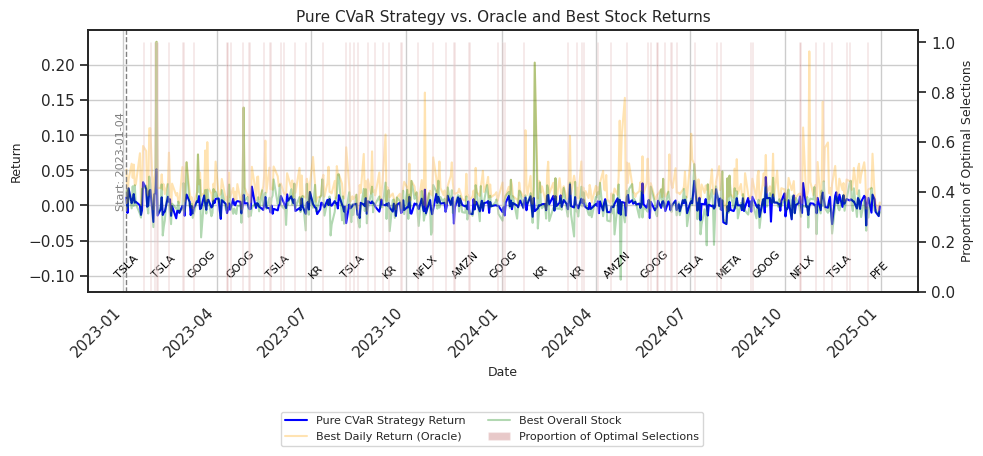

In [30]:
plot_blended_vs_oracles(
    dates=YData["Date"].iloc[HOLD:].reset_index(drop=True),
    reward_blended=results02["reward_blended_all"].mean(axis=0),
    data=YData[tickers],
    picked_stock_blended_all=results02["picked_stock_blended_all"],
    optimal_stock_all=results02["optimal_stock_all"],
    model='Pure CVaR',
    save_image="blended_ucb02",
    asset_names=tickers,
    HOLD=HOLD
)

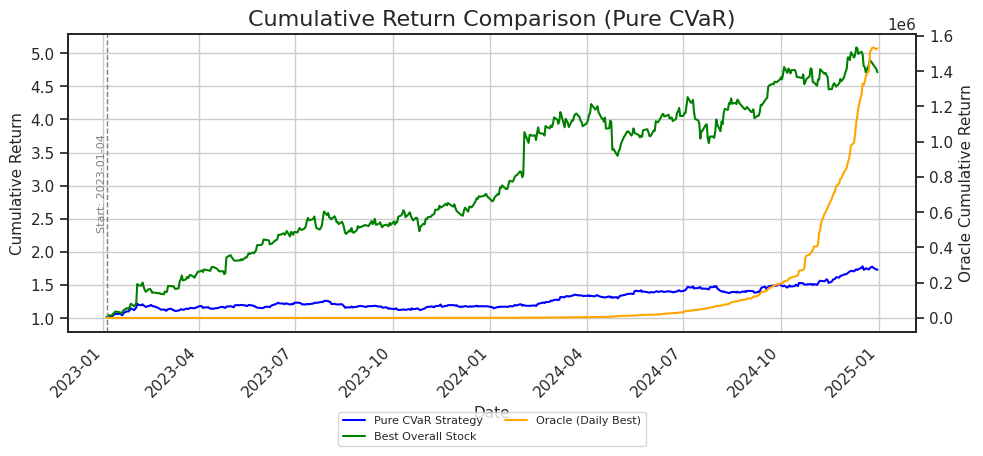

In [31]:
plot_cumulative_return_comparison(
    dates=YData["Date"].iloc[HOLD:].reset_index(drop=True),
    reward_blended=results02["reward_blended_all"].mean(axis=0),
    data=YData[tickers],
    save_image='blended_ucbcumu_return02',
    model='Pure CVaR',
    HOLD=1,
    asset_names=tickers  # optional
)

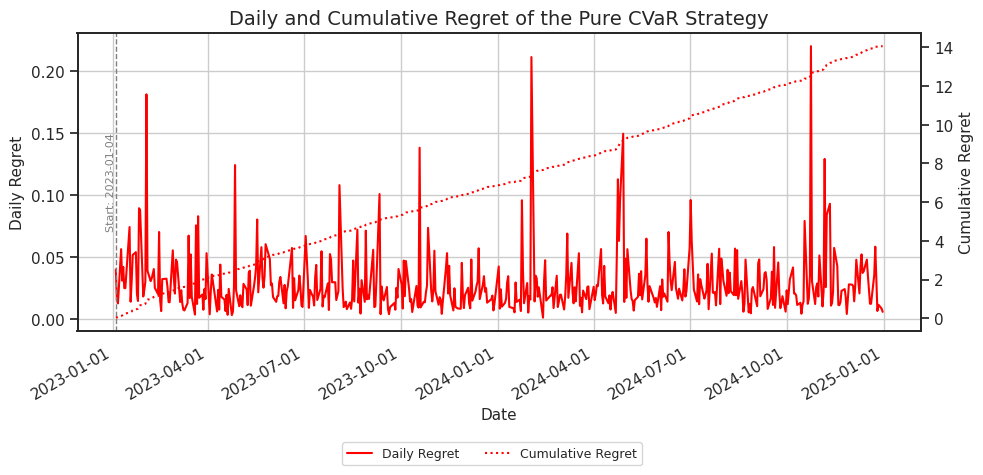

In [32]:
plot_blended_daily_and_cumulative_regret(
    dates=YData["Date"].iloc[HOLD:].reset_index(drop=True),
    regret_blended_all=results02["regret_blended_all"],
    model='Pure CVaR',
    save_image="blended_ucb02_regret"
)

In [33]:
avg_weight_allocations02 = results02["weights_all"].mean(axis=0)  # shape: (T, K)
columns=[tickers[i] for i in range(avg_weight_allocations02.shape[1])]

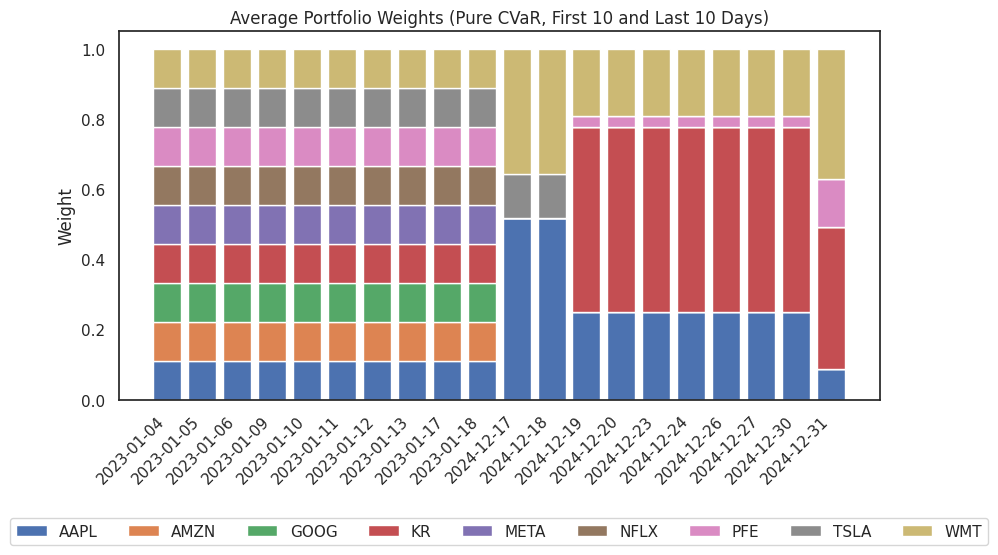

In [34]:
# Combine first 5 and last 5 rows (stacked vertically)
first_5 = avg_weight_allocations02[:10]
last_5 = avg_weight_allocations02[-10:]
weights_to_plot = np.vstack([first_5, last_5])

# Build x-axis labels (dates)
plot_dates = YData["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels = list(plot_dates[:10]) + list(plot_dates[-10:])
date_labels = [d.strftime("%Y-%m-%d") for d in date_labels]

# Create DataFrame for easier plotting
df_weights = pd.DataFrame(weights_to_plot, columns=columns, index=date_labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(df_weights))

for asset in df_weights.columns:
    ax.bar(df_weights.index, df_weights[asset], bottom=bottom, label=asset)
    bottom += df_weights[asset].values

ax.set_ylabel("Weight")
ax.set_title(r"Average Portfolio Weights (Pure CVaR, First 10 and Last 10 Days)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=9)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("weights02.png", dpi=300, bbox_inches="tight")
plt.show()

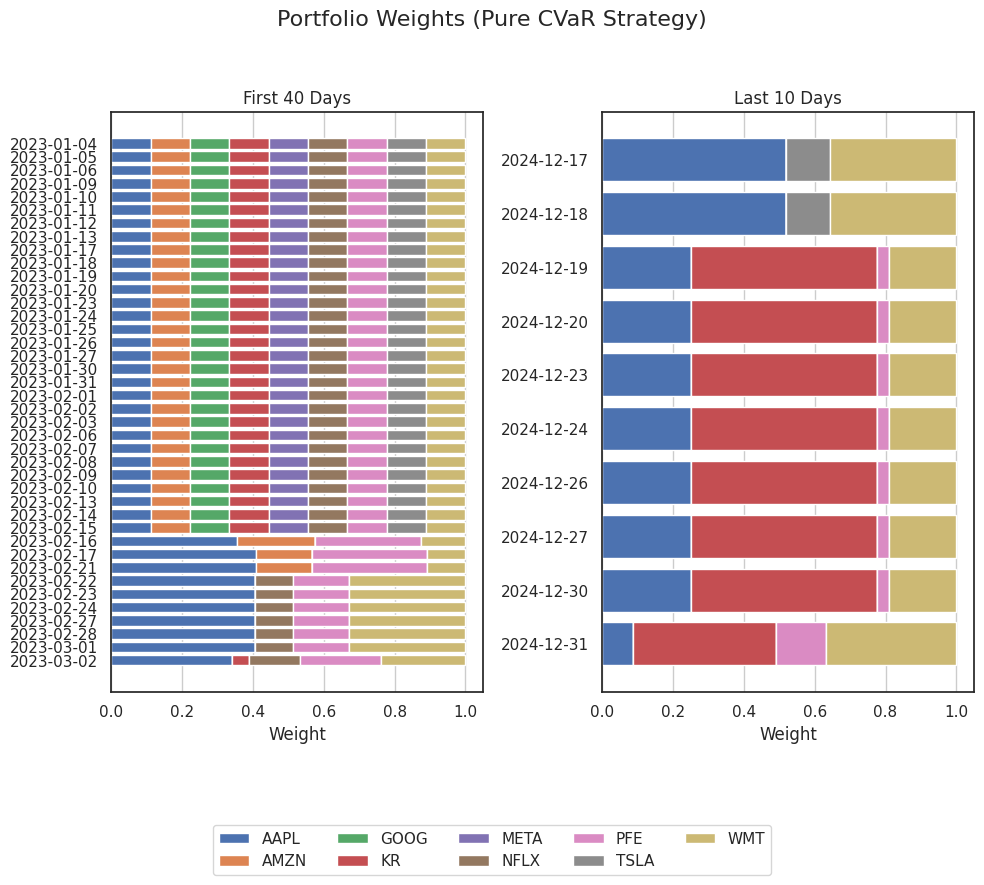

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Extract weights for the Pure CVaR method ===
first_40 = avg_weight_allocations02[:40]
last_10 = avg_weight_allocations02[-10:]

# Build date labels
plot_dates = YData["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels_first = plot_dates[:40].dt.strftime("%Y-%m-%d").tolist()
date_labels_last = plot_dates[-10:].dt.strftime("%Y-%m-%d").tolist()

# Convert to DataFrames for plotting
df_first = pd.DataFrame(first_40, columns=columns, index=date_labels_first)
df_last = pd.DataFrame(last_10, columns=columns, index=date_labels_last)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)

for ax, df_weights, title in zip(
    axes, [df_first, df_last], ["First 40 Days", "Last 10 Days"]
):
    left = np.zeros(len(df_weights))
    for asset in df_weights.columns:
        ax.barh(df_weights.index, df_weights[asset], left=left, label=asset)
        left += df_weights[asset].values

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Weight")
    ax.invert_yaxis()
    ax.grid(True, axis="x")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.03), ncol=5)

plt.suptitle("Portfolio Weights (Pure CVaR Strategy)", fontsize=16)
plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig("weights02_twopanel.png", dpi=300, bbox_inches="tight")
plt.show()

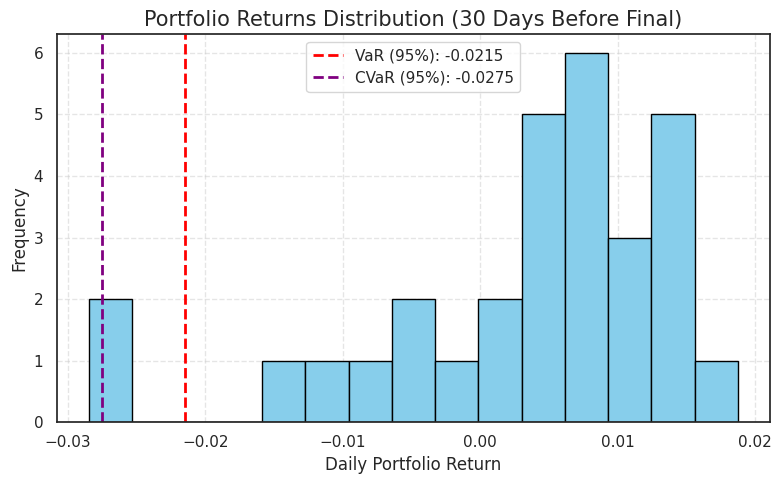

In [36]:
# Extract weights (T=501, K=9)
weights = results02["weights_all"][0]  # shape: (501, 9)

# Compute asset returns
returns = YData[tickers].pct_change().dropna().values  # shape: (500, 9)

# Trim weights to match length of returns
weights = weights[:len(returns)]  # shape: (500, 9)

# Compute portfolio returns
portfolio_returns = np.sum(weights * returns, axis=1)  # shape: (500,)

# Use last 30 days up to (but not including) the final day
window_size = 30
historical_returns = portfolio_returns[-(window_size + 1):-1]  # shape: (30,)

# Compute VaR and CVaR
beta = 0.95
VaR_95 = np.percentile(historical_returns, (1 - beta) * 100)
CVaR_95 = historical_returns[historical_returns <= VaR_95].mean()

# Plot histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(historical_returns, bins=15, color="skyblue", edgecolor="black")

# Annotate VaR and CVaR
ax.axvline(VaR_95, color="red", linestyle="--", linewidth=2, label=f"VaR (95%): {VaR_95:.4f}")
ax.axvline(CVaR_95, color="purple", linestyle="--", linewidth=2, label=f"CVaR (95%): {CVaR_95:.4f}")

ax.set_title("Portfolio Returns Distribution (30 Days Before Final)", fontsize=15)
ax.set_xlabel("Daily Portfolio Return")
ax.set_ylabel("Frequency")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("portfolioCVaR.png", dpi=300, bbox_inches="tight")
plt.show()

### Pure UCB Case: $\lambda=1, \varepsilon=0$

In [37]:
HOLD = 1
# Start the timer
start_time = time.time()
# Run the blended strategy
results = compute_combined_portfolios(
    YData[tickers],
    lambda_=1,
    EPSILON=0,
    HOLD=HOLD,
    NEPISODES=1
)
# Stop the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

print(f"The code took {execution_time:.2f} seconds to execute.")

==== CVaR Initialization Debug ====
Training mode:
Shape of CVaR history matrix: (0, 9)
First 3 returns:
 []
Last 3 returns:
 []
Computed w_cvar (rounded): [0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111]
Stored weight_combined on Day 0: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
The code took 2.89 seconds to execute.


In [38]:
blended_pureucb_results = results
# blended_pureucb_results

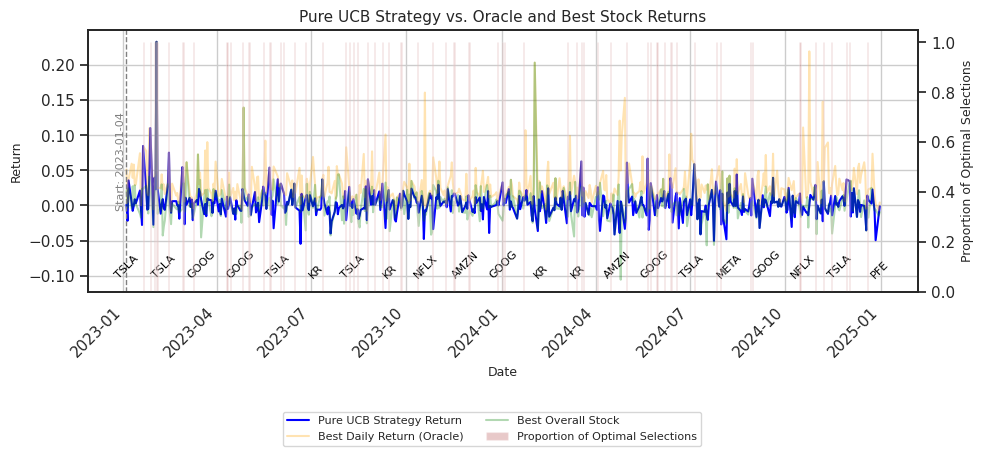

In [39]:
plot_blended_vs_oracles(
    dates=YData["Date"].iloc[HOLD:].reset_index(drop=True),
    reward_blended=results["reward_blended_all"].mean(axis=0),
    data=YData[tickers],
    picked_stock_blended_all=results["picked_stock_blended_all"],
    optimal_stock_all=results["optimal_stock_all"],
    model='Pure UCB',
    save_image="blended_ucb01",
    asset_names=tickers,
    HOLD=HOLD
)

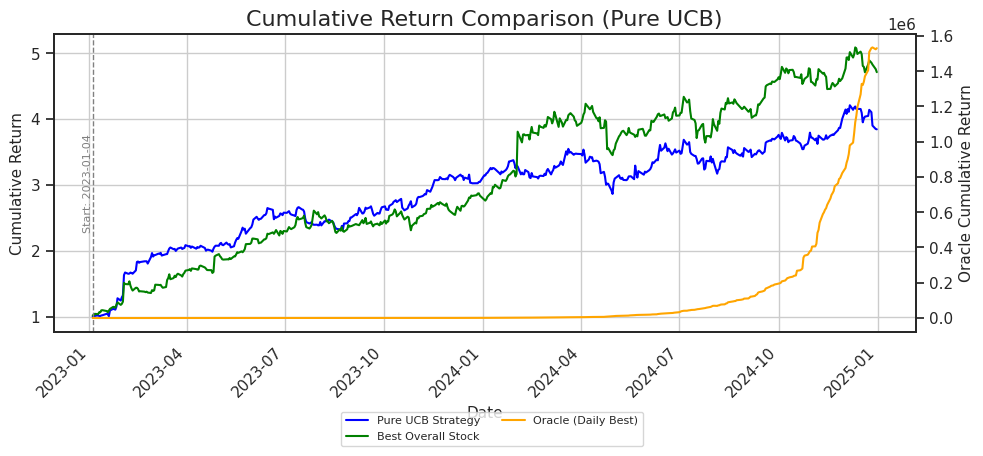

In [40]:
plot_cumulative_return_comparison(
    dates=YData["Date"].iloc[HOLD:].reset_index(drop=True),
    reward_blended=results["reward_blended_all"].mean(axis=0),
    data=YData[tickers],
    save_image='blended01return',
    model='Pure UCB',
    HOLD=1,
    asset_names=tickers  # optional
)

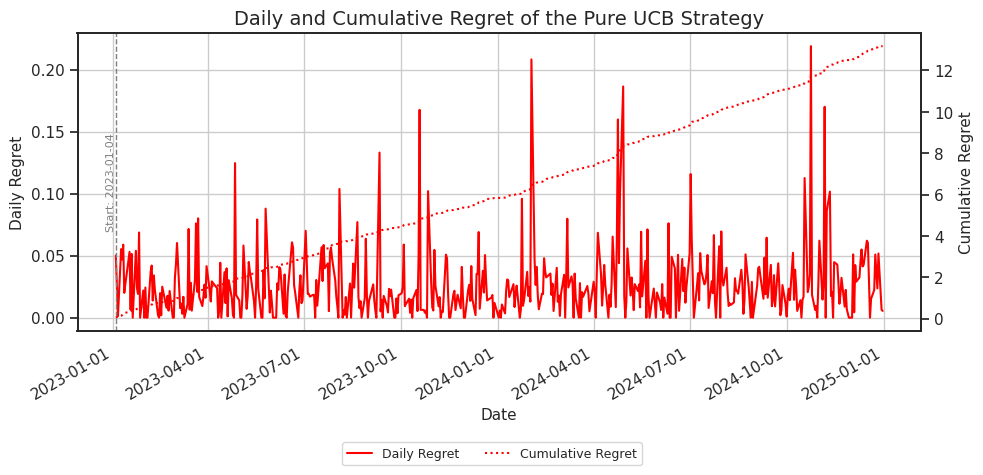

In [41]:
plot_blended_daily_and_cumulative_regret(
    dates=YData["Date"].iloc[HOLD:].reset_index(drop=True),
    regret_blended_all=results["regret_blended_all"],
    model='Pure UCB',
    save_image="blended_ucb01_regret"
)

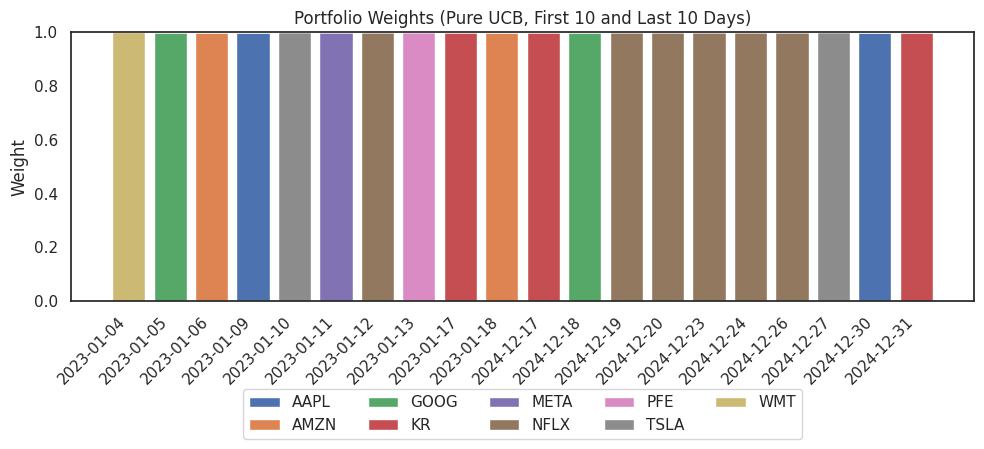

In [42]:
avg_weight_allocations01 = results["weights_all"][0]#.mean(axis=0)  # shape: (T, K)
columns=[tickers[i] for i in range(avg_weight_allocations01.shape[1])]

# Combine first 5 and last 5 rows (stacked vertically)
first_5 = avg_weight_allocations01[:10]
last_5 = avg_weight_allocations01[-10:]
weights_to_plot = np.vstack([first_5, last_5])

# Build x-axis labels (dates)
plot_dates = YData["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels = list(plot_dates[:10]) + list(plot_dates[-10:])
date_labels = [d.strftime("%Y-%m-%d") for d in date_labels]

# Create DataFrame for easier plotting
df_weights = pd.DataFrame(weights_to_plot, columns=columns, index=date_labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(df_weights))

for asset in df_weights.columns:
    ax.bar(df_weights.index, df_weights[asset], bottom=bottom, label=asset)
    bottom += df_weights[asset].values

ax.set_ylabel("Weight")
ax.set_title(r"Portfolio Weights (Pure UCB, First 10 and Last 10 Days)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=5)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("weights01.png", dpi=300, bbox_inches="tight")
plt.show()

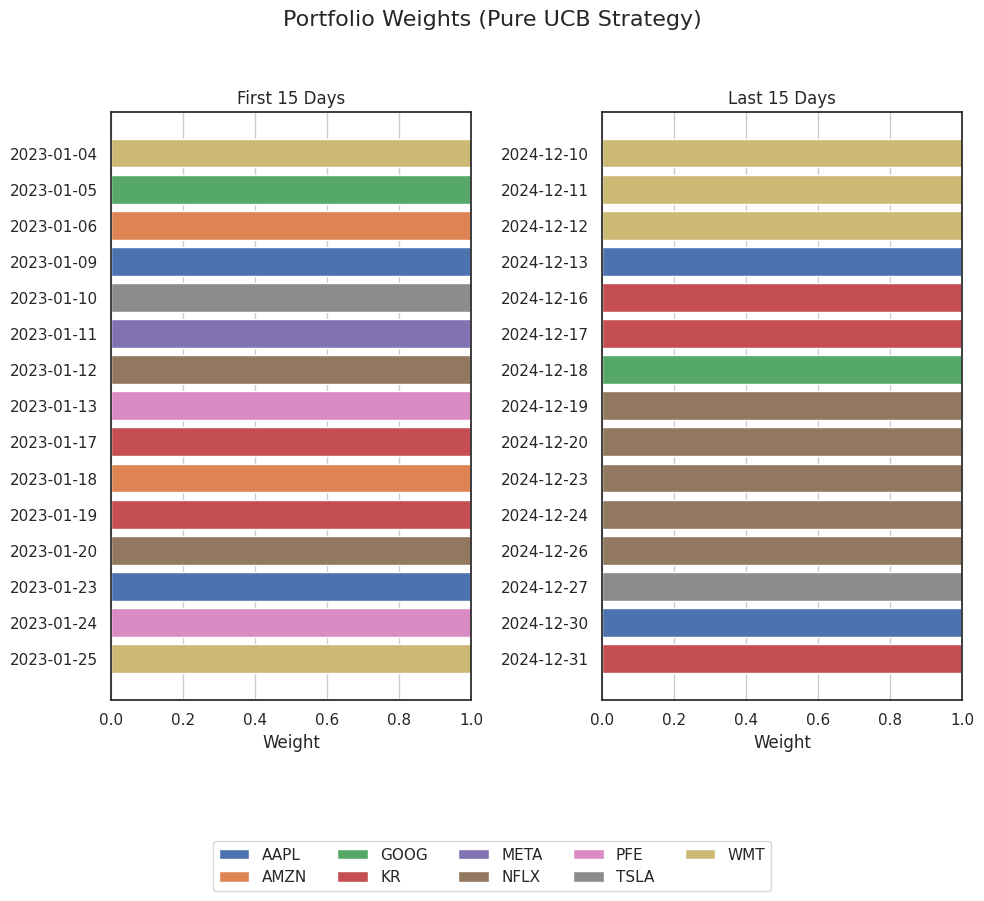

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract first and last 15 days of weights
first_15 = avg_weight_allocations01[:15]
last_15 = avg_weight_allocations01[-15:]

# Date labels for each panel
plot_dates = YData["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels_first = plot_dates[:15].dt.strftime("%Y-%m-%d").tolist()
date_labels_last = plot_dates[-15:].dt.strftime("%Y-%m-%d").tolist()

# Convert to DataFrames for easier plotting
df_first = pd.DataFrame(first_15, columns=columns, index=date_labels_first)
df_last = pd.DataFrame(last_15, columns=columns, index=date_labels_last)

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)

for ax, df_weights, title in zip(
    axes, [df_first, df_last], ["First 15 Days", "Last 15 Days"]
):
    left = np.zeros(len(df_weights))
    for asset in df_weights.columns:
        ax.barh(df_weights.index, df_weights[asset], left=left, label=asset)
        left += df_weights[asset].values

    ax.set_title(title)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Weight")
    ax.invert_yaxis()  # So dates go from bottom to top
    ax.grid(True, axis="x")

# Legend (shared below both plots)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=5)

plt.suptitle("Portfolio Weights (Pure UCB Strategy)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("weights01_twopanel.png", dpi=300, bbox_inches="tight")
plt.show()

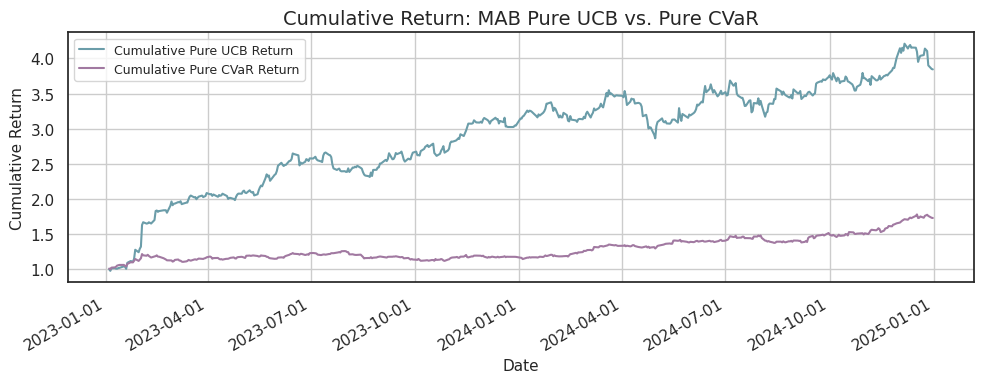

In [44]:
# Align cumulative blended return
avg_return01 = results["reward_blended_all"].mean(axis=0)
cumulative_blended01 = np.cumprod(1 + avg_return01)
avg_return02 = results02["reward_blended_all"].mean(axis=0)
cumulative_blended02 = np.cumprod(1 + avg_return02)

# Align x-axis dates
x_dates = pd.to_datetime(YData["Date"].iloc[HOLD:HOLD + 1 + len(cumulative_blended01)].reset_index(drop=True))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x_dates, cumulative_blended01, label="Cumulative Pure UCB Return", color="#6B9DA9")      # pastel blue #AEC6CF
ax.plot(x_dates, cumulative_blended02, label="Cumulative Pure CVaR Return", color="#A179A1")  # pastel purple #D8BFD8

ax.set_title("Cumulative Return: MAB Pure UCB vs. Pure CVaR", fontsize=14)
ax.set_xlabel("Date", fontsize=11)
ax.set_ylabel("Cumulative Return", fontsize=11)
ax.grid(True)
ax.legend(loc="upper left", fontsize=9)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig("ucb_vs_blended01_cumulative.png", dpi=300, bbox_inches="tight")
plt.show()

The purple plot is the cumulative return based on pure CVaR computation, so it's a little more conservative in trading and has a slightly lower return at the end of the trading period. The pastel blue plot is the cumulative return with a pure (nonstationary case, i.e. exponential decyaing learning) UCB result. This plot shows that taking care of risk misses out on some returns.

## Testing Phase - Jan. 2025 through May 16, 2025

### Pure CVaR: $\lambda=0, \varepsilon=0$

In [45]:
HOLD = 1
start_time = time.time()
# Run the blended strategy
results03 = compute_combined_portfolios(
    YData2025[tickers],
    lambda_=0,     # blend MAB and CVaR
    EPSILON=0,     # allow exploration
    HOLD=HOLD,
    init_qvalues=results02["final_qvalues_all"].mean(axis=0),    # shape: (K,)
    init_nactions=results02["final_nactions_all"].mean(axis=0),  # shape: (K,)
    ini_weight=results02["weights_all"].mean(axis=0)[-1, :],   # shape: (K,)
    NEPISODES=1,    # or whatever number you like
    data_old=YData[tickers]
)
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

print(f"The code took {execution_time:.2f} seconds to execute.")

==== CVaR Initialization Debug ====
Testing mode:
Shape of CVaR history matrix: (30, 9)
First 3 returns:
 [[ 0.01342226 -0.00449141  0.01673482  0.00068946  0.00057764  0.02802316
   0.00241932  0.05618605 -0.00201784]
 [ 0.00114023  0.01442739  0.01572385  0.00068892  0.01206707  0.02865241
   0.0096541   0.0214324   0.02997155]
 [ 0.003154   -0.00845509 -0.01252921 -0.00843369  0.00789533  0.01438044
  -0.0063745  -0.01147399  0.00669732]]
Last 3 returns:
 [[-0.01324219 -0.01453426 -0.01552519 -0.00669215 -0.00586716 -0.01795185
   0.00225901 -0.04947923 -0.01217808]
 [-0.01326341 -0.01094971 -0.00695726 -0.01780556 -0.01428795 -0.00784529
  -0.00751313 -0.03301209 -0.01189173]
 [-0.00705787 -0.00863083 -0.01167685 -0.00130651 -0.00969141 -0.01011737
   0.00416354 -0.03251002 -0.0024291 ]]
Computed w_cvar (rounded): [0.     0.     0.     0.4681 0.     0.     0.4014 0.     0.1305]
Stored weight_combined on Day 0: [0.     0.     0.     0.4681 0.     0.     0.4014 0.     0.1305]
The cod

In [46]:
avg_weight_allocations03 = results03["weights_all"].mean(axis=0)  # shape: (T, K)
columns=[tickers[i] for i in range(avg_weight_allocations03.shape[1])]

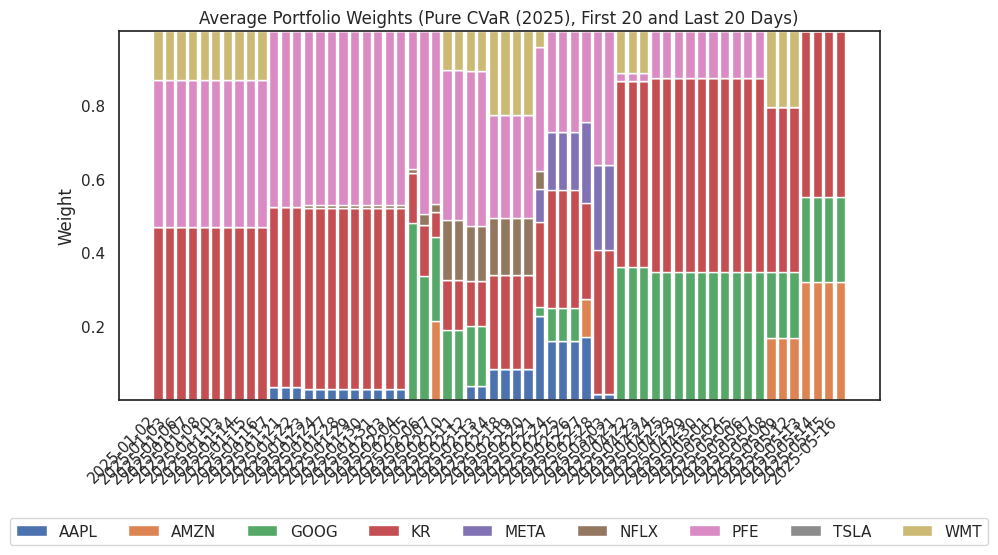

In [47]:
# Combine first 5 and last 5 rows (stacked vertically)
first_5 = avg_weight_allocations03[:40]
last_5 = avg_weight_allocations03[-20:]
weights_to_plot = np.vstack([first_5, last_5])

# Build x-axis labels (dates)
plot_dates = YData2025["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels = list(plot_dates[:40]) + list(plot_dates[-20:])
date_labels = [d.strftime("%Y-%m-%d") for d in date_labels]

# Create DataFrame for easier plotting
df_weights = pd.DataFrame(weights_to_plot, columns=columns, index=date_labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(df_weights))

for asset in df_weights.columns:
    ax.bar(df_weights.index, df_weights[asset], bottom=bottom, label=asset)
    bottom += df_weights[asset].values

ax.set_ylabel("Weight")
ax.set_title(r"Average Portfolio Weights (Pure CVaR (2025), First 20 and Last 20 Days)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=9)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("weights03.png", dpi=300, bbox_inches="tight")
plt.show()

### Pure UCB: $\lambda=1, \varepsilon=0$

In [48]:
HOLD = 1
start_time = time.time()
# Run the blended strategy
results04 = compute_combined_portfolios(
    YData2025[tickers],
    lambda_=1,     # blend MAB and CVaR
    EPSILON=0,     # allow exploration
    HOLD=HOLD,
    init_qvalues=results["final_qvalues_all"].mean(axis=0),    # shape: (K,)
    init_nactions=results["final_nactions_all"].mean(axis=0),  # shape: (K,)
    ini_weight=results["weights_all"].mean(axis=0)[-1, :],   # shape: (K,)
    NEPISODES=2,    # or whatever number you like
    data_old=YData[tickers]
)
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

print(f"The code took {execution_time:.2f} seconds to execute.")

==== CVaR Initialization Debug ====
Testing mode:
Shape of CVaR history matrix: (30, 9)
First 3 returns:
 [[ 0.01342226 -0.00449141  0.01673482  0.00068946  0.00057764  0.02802316
   0.00241932  0.05618605 -0.00201784]
 [ 0.00114023  0.01442739  0.01572385  0.00068892  0.01206707  0.02865241
   0.0096541   0.0214324   0.02997155]
 [ 0.003154   -0.00845509 -0.01252921 -0.00843369  0.00789533  0.01438044
  -0.0063745  -0.01147399  0.00669732]]
Last 3 returns:
 [[-0.01324219 -0.01453426 -0.01552519 -0.00669215 -0.00586716 -0.01795185
   0.00225901 -0.04947923 -0.01217808]
 [-0.01326341 -0.01094971 -0.00695726 -0.01780556 -0.01428795 -0.00784529
  -0.00751313 -0.03301209 -0.01189173]
 [-0.00705787 -0.00863083 -0.01167685 -0.00130651 -0.00969141 -0.01011737
   0.00416354 -0.03251002 -0.0024291 ]]
Computed w_cvar (rounded): [0.     0.     0.     0.4681 0.     0.     0.4014 0.     0.1305]
Stored weight_combined on Day 0: [1. 0. 0. 0. 0. 0. 0. 0. 0.]
The code took 1.47 seconds to execute.


In [49]:
avg_weight_allocations04 = results04["weights_all"].mean(axis=0)  # shape: (T, K)
columns=[tickers[i] for i in range(avg_weight_allocations04.shape[1])]

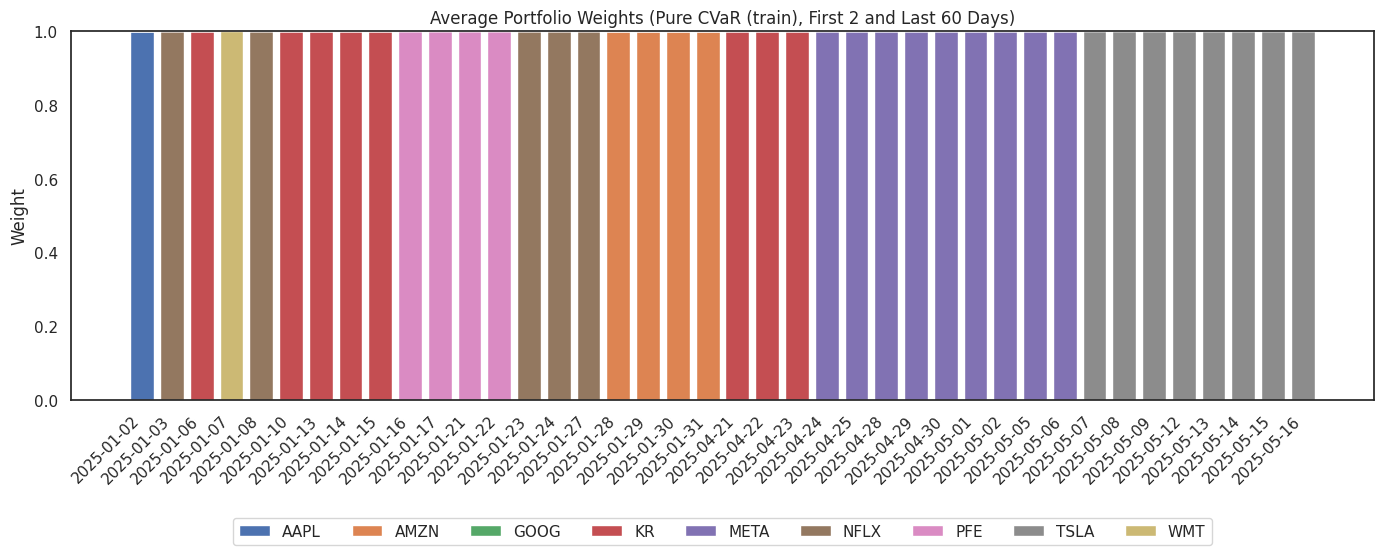

In [50]:
# Combine first 5 and last 5 rows (stacked vertically)
first_5 = avg_weight_allocations04[:20]
last_5 = avg_weight_allocations04[-20:]
weights_to_plot = np.vstack([first_5, last_5])

# Build x-axis labels (dates)
plot_dates = YData2025["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels = list(plot_dates[:20]) + list(plot_dates[-20:])
date_labels = [d.strftime("%Y-%m-%d") for d in date_labels]

# Create DataFrame for easier plotting
df_weights = pd.DataFrame(weights_to_plot, columns=columns, index=date_labels)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(df_weights))

for asset in df_weights.columns:
    ax.bar(df_weights.index, df_weights[asset], bottom=bottom, label=asset)
    bottom += df_weights[asset].values

ax.set_ylabel("Weight")
ax.set_title(r"Average Portfolio Weights (Pure CVaR (train), First 2 and Last 60 Days)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=9)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("weights04.png", dpi=300, bbox_inches="tight")
plt.show()

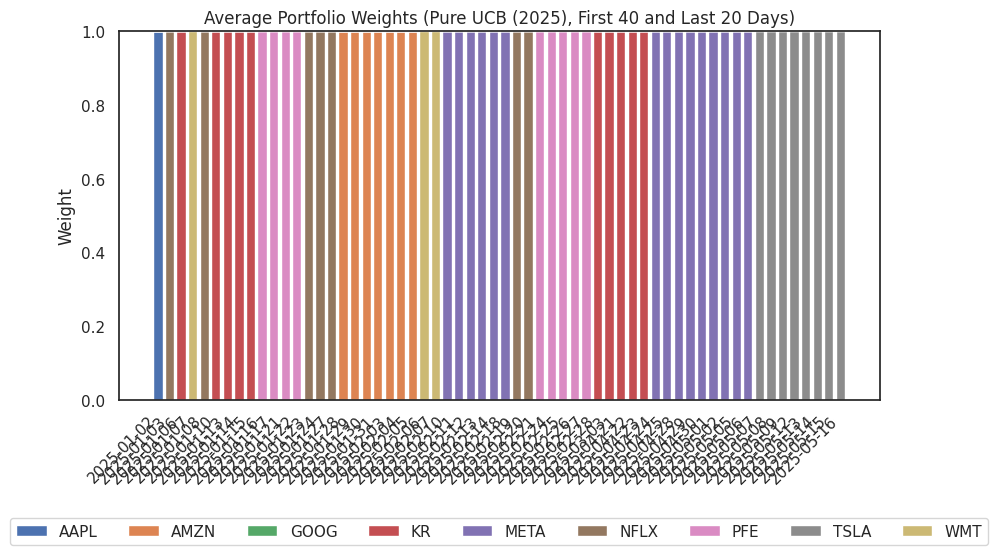

In [51]:
# Combine first 5 and last 5 rows (stacked vertically)
first_5 = avg_weight_allocations04[:40]
last_5 = avg_weight_allocations04[-20:]
weights_to_plot = np.vstack([first_5, last_5])

# Build x-axis labels (dates)
plot_dates = YData2025["Date"].iloc[HOLD:].reset_index(drop=True)
date_labels = list(plot_dates[:40]) + list(plot_dates[-20:])
date_labels = [d.strftime("%Y-%m-%d") for d in date_labels]

# Create DataFrame for easier plotting
df_weights = pd.DataFrame(weights_to_plot, columns=columns, index=date_labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(df_weights))

for asset in df_weights.columns:
    ax.bar(df_weights.index, df_weights[asset], bottom=bottom, label=asset)
    bottom += df_weights[asset].values

ax.set_ylabel("Weight")
ax.set_title(r"Average Portfolio Weights (Pure UCB (2025), First 40 and Last 20 Days)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=9)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("weights04v2.png", dpi=300, bbox_inches="tight")
plt.show()

The main code for a quick recap:

In [52]:
def compute_combined_portfolios(
    data,
    NEPISODES,
    lambda_,
    EPSILON,
    HOLD=1,
    ALPHA=0.8,
    SEED_VALUE=1234,
    data_old=None,
    ini_weight=None,
    init_qvalues=None,
    init_nactions=None
):
    import numpy as np
    import cvxpy as cp
    import pandas as pd
    from numpy.random import seed, rand, randint

    min_history = 30
    returns = data.pct_change().dropna().reset_index(drop=True)
    NK = data.shape[1]
    TMAX = data.shape[0] - HOLD - 1
    date_index = data.index[HOLD:]

    reward_blended_all = np.zeros((NEPISODES, TMAX + 1))
    regret_blended_all = np.zeros((NEPISODES, TMAX + 1))
    picked_stock_blended_all = np.zeros((NEPISODES, TMAX + 1), dtype=int)
    optimal_stock_all = np.zeros((NEPISODES, TMAX + 1), dtype=int)

    final_qvalues_all = np.zeros((NEPISODES, NK))
    final_nactions_all = np.zeros((NEPISODES, NK))
    weight_record = np.zeros((NEPISODES, TMAX + 1, NK))

    for episode in range(NEPISODES):
        seed(SEED_VALUE + episode)

        qvalues = np.zeros(NK) if init_qvalues is None else init_qvalues.copy()
        nactions = np.zeros(NK) if init_nactions is None else init_nactions.copy()
        qvalues_up = np.zeros(NK)
        reward_queue = np.zeros((HOLD, 2))

        last_valid_cvar = np.ones(NK) / NK
        beta = 0.95
        arm_order = np.random.permutation(NK)

        for tt in range(0, TMAX + 1):
            untouched = np.where(nactions == 0)[0]

            # === Selection logic ===
            if data_old is None and len(untouched) > 0:
                for arm in arm_order:
                    if arm in untouched:
                        action = arm
                        break
            else:
                if EPSILON > 0 and rand() < EPSILON:
                    action = randint(NK)
                else:
                    action = np.argmax(qvalues_up)

            nactions[action] += 1

            # Compute reward
            ret = (data.iloc[tt + HOLD] - data.iloc[tt]) / data.iloc[tt]
            reward = ret.iloc[action]
            reward_queue[HOLD - 1, 0] = reward
            reward_queue[HOLD - 1, 1] = action

            # Q-value update (alpha-learning)
            alpha = ALPHA
            qvalues[int(reward_queue[0, 1])] += alpha * (reward_queue[0, 0] - qvalues[int(reward_queue[0, 1])])

            # UCB1 update
            for a in range(NK):
                if nactions[a] == 0:
                    qvalues_up[a] = np.max(qvalues) + 1.0
                else:
                    qvalues_up[a] = qvalues[a] + np.sqrt(np.log(tt + 1) / nactions[a])

            reward_queue[0:HOLD - 1, :] = reward_queue[1:HOLD, :]

            # --- CVaR Optimization ---
            if data_old is not None:
                data_old_ret = data_old.pct_change().dropna().reset_index(drop=True)
                if tt < min_history:
                    num_needed_from_train = min_history - tt
                    recent_train_returns = data_old_ret.iloc[-num_needed_from_train:]
                    recent_test_returns = returns.iloc[:tt]
                    history = pd.concat([recent_train_returns, recent_test_returns], axis=0).values
                else:
                    history = returns.iloc[tt - min_history:tt].values
            else:
                history = returns.iloc[max(0, tt - min_history):tt].values

            if history.shape[0] < min_history:
                w_cvar = last_valid_cvar
            else:
                m = history.shape[0]
                w = cp.Variable(NK)
                a = cp.Variable()
                z = cp.Variable(m)
                constraints = [w >= 0, cp.sum(w) == 1, z >= -history @ w - a, z >= 0]
                objective = cp.Minimize(a + (1 / ((1 - beta) * m)) * cp.sum(z))
                prob = cp.Problem(objective, constraints)
                result = prob.solve(solver='ECOS', verbose=False)

                if w.value is not None:
                    w_cvar = np.array(w.value).flatten()
                    last_valid_cvar = w_cvar.copy()
                else:
                    w_cvar = last_valid_cvar

            if episode == 0 and tt == 0:
                print("==== CVaR Initialization Debug ====")
                print("Testing mode:" if data_old is not None else "Training mode:")
                print("Shape of CVaR history matrix:", history.shape)
                print("First 3 returns:\n", history[:3])
                print("Last 3 returns:\n", history[-3:])
                print("Computed w_cvar (rounded):", np.round(w_cvar, 4))
                print("===================================")

            e_at = np.zeros(NK)
            e_at[action] = 1.0

            if tt == 0 and ini_weight is not None and data_old is None:
                w_combined = ini_weight
            else:
                if lambda_ == 0:
                    w_combined = w_cvar
                elif lambda_ == 1:
                    w_combined = e_at
                else:
                    w_combined = lambda_ * e_at + (1 - lambda_) * w_cvar

            if episode == 0 and tt == 0:
                print("Stored weight_combined on Day 0:", w_combined.round(4))

            weight_record[episode, tt, :] = w_combined

            blended_return = np.dot(w_combined, ret.values)
            best_return = ret.max()
            best_stock = ret.values.argmax()
            regret = best_return - blended_return

            reward_blended_all[episode, tt] = blended_return
            regret_blended_all[episode, tt] = regret
            picked_stock_blended_all[episode, tt] = action
            optimal_stock_all[episode, tt] = best_stock

        final_qvalues_all[episode] = qvalues
        final_nactions_all[episode] = nactions

    return {
        "dates": date_index,
        "reward_blended_all": reward_blended_all,
        "regret_blended_all": regret_blended_all,
        "picked_stock_blended_all": picked_stock_blended_all,
        "optimal_stock_all": optimal_stock_all,
        "final_qvalues_all": final_qvalues_all,
        "final_nactions_all": final_nactions_all,
        "weights_all": weight_record
    }
